# A list of tasks


1.   Make sure everything runs correctly with the original test_sentence that we implemented during the TA-led exercise.
2.   Find a way to replace 3 with the CONTEXT_SIZE variable in the `predict` function of the `class CBOWModeler(nn.Module)`. Examine the performance of the model when you change `CONTEXT_SIZE=3` to `CONTEXT_SIZE=4`
3.  Run this model with the Obama dataset (on the google drive, in the `10 - data` directory; let me know if you have any issues with this). Here is how you build an array out of it:
        with open("speeches_combined.txt", "r") as f:
            text=f.read()



4. Run the model by reading in the following dataset with the following helper functions:
```
    test_sentence = read_data('https://www.gutenberg.org/files/57884/57884-0.txt')
    def read_data(file_path):
        tokenizer = RegexpTokenizer(r'\w+')
        data = urllib.request.urlopen(file_path)
        data = data.read().decode('utf8')
        tokenized_data = word_tokenize(data)
        stop_words = set(stopwords.words('english'))
        stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
        cleaned_words = [ i for i in tokenized_data if i not in stop_words ]
        return(cleaned_words)
```


5. Projecting your embedding into lower-dimenesional space by using t-SNE. Here are a couple references:

* https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* Some sample code for this task:

```
model.write_embedding_to_file('embeddings.npy') # defined in class CBOWModeler(nn.Module):
X = np.load('embeddings.npy')
from sklearn.manifold import TSNE
X = np.load('embeddings.npy') 
    # with the test_sentence from example 1, X should be EMBEDDING_DIM x 195
X_embedded = TSNE(n_components=2).fit_transform(X)
    # with the test_sentence from example 1, X_embedded should be 2 x 195
X_embedded.shape
plt.scatter(X_embedded[:,0],X_embedded[:,1])
```

6. You just implemented the CBOW algorithm. Try to implement a skip-gram instead! (Answer in the tutorial link.)

7. Tutorial on the implementation of BERT: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#11-using-colab-gpu-for-training

# Word2Vec
Code from here: https://srijithr.gitlab.io/post/word2vec/ \
Author: Srijith Rajamohan based off the work by Robert Guthrie \
*Another, almost identical, Word2Vec Script provided by the lecturer: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html*

In [ ]:
# Import all the packages that we will need
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Author: Srijith Rajamohan based off the work by Robert Guthrie

torch.manual_seed(1) # Sets the seed for generating random numbers. Returns a torch.Generator object.

CONTEXT_SIZE = 3 # how many words are we using to predict the "target?"; 
    # PS: good coding practise to capitalize "global variables" like that!
EMBEDDING_DIM = 10 # size of the vector representing each input word

test_sentence = """Empathy for the poor may not come easily to people who never experienced it. They may blame the victims and insist their predicament can be overcome through determination and hard work.
But they may not realize that extreme poverty can be psychologically and physically incapacitating — a perpetual cycle of bad diets, health care and education exacerbated by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human afflictions” and realized the power of empathy to help us understand it. It was neither an abstract problem nor political symbol, but something he endured growing up destitute in rural Kansas and having spent years documenting poverty throughout the world, including the United States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()

# test_sentence # previous paragraph converted to a list of words

In [ ]:
# format test_sentence into entries of [input, label] (ie [ [context_word_1, ..., context_word_CONTEXT_SIZE], target_word] )
ngrams = []
for i in range(len(test_sentence) - CONTEXT_SIZE):
    tup = [test_sentence[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
    ngrams.append((tup,test_sentence[i + CONTEXT_SIZE]))
# print the first 3, just so you can see what they look like
print(ngrams)

[(['Empathy', 'for', 'the'], 'poor'), (['for', 'the', 'poor'], 'may'), (['the', 'poor', 'may'], 'not'), (['poor', 'may', 'not'], 'come'), (['may', 'not', 'come'], 'easily'), (['not', 'come', 'easily'], 'to'), (['come', 'easily', 'to'], 'people'), (['easily', 'to', 'people'], 'who'), (['to', 'people', 'who'], 'never'), (['people', 'who', 'never'], 'experienced'), (['who', 'never', 'experienced'], 'it.'), (['never', 'experienced', 'it.'], 'They'), (['experienced', 'it.', 'They'], 'may'), (['it.', 'They', 'may'], 'blame'), (['They', 'may', 'blame'], 'the'), (['may', 'blame', 'the'], 'victims'), (['blame', 'the', 'victims'], 'and'), (['the', 'victims', 'and'], 'insist'), (['victims', 'and', 'insist'], 'their'), (['and', 'insist', 'their'], 'predicament'), (['insist', 'their', 'predicament'], 'can'), (['their', 'predicament', 'can'], 'be'), (['predicament', 'can', 'be'], 'overcome'), (['can', 'be', 'overcome'], 'through'), (['be', 'overcome', 'through'], 'determination'), (['overcome', 'thr

In [ ]:
# What and how many unique words do we have?
vocab = set(test_sentence)
print("Length of vocabulary",len(vocab))

Length of vocabulary 195


In [ ]:
# give each unique word an integer label
word_to_ix = {word: i for i, word in enumerate(vocab)}
# word_to_ix 

Some helper functions

In [ ]:
def get_key(word_id): # indices from 0 to 194 inclusively
    for key,val in word_to_ix.items():
        if(val == word_id):
            return(key)

def cluster_embeddings(filename,nclusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X,center)

    for i in np.arange(0,distances.shape[1]):
        word_id = np.argmin(distances[:,i])
        #print(word_id)
        get_key(word_id)

Create your model:

In [ ]:
class CBOWModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
        # Embedding function: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
        out1 = F.relu(self.linear1(embeds)) # output of first layer
        out2 = self.linear2(out1)           # output of second layer
        #print(embeds)
        log_probs = F.log_softmax(out2, dim=1) # REMINDER: this is a LOG of a probability (hence the -ve values!)
        return log_probs

    def predict(self,input):
        new_input=[]
        context_idxs = torch.tensor([word_to_ix[w] for w in input], dtype=torch.long)
        res = self.forward(context_idxs)
        res_arg = torch.argmax(res)
        new_word=get_key(res_arg)
        #for i in range(CONTEXT_SIZE-2): # 0, 1
         #   new_input.append(input[i+1]) #input[1], input[2]
        new_input.append(input[1])
        new_input.append(input[2])
        new_input.append(new_word)
        print(new_word)
        return(new_input)

    # def freeze_layer(self,layer):
    #     for name,child in model.named_children():
    #         print(name,child)
    #         if(name == layer):
    #             for names,params in child.named_parameters():
    #                 print(names,params)
    #                 print(params.size())
    #                 params.requires_grad= False

    # def print_layer_parameters(self):
    #     for name,child in model.named_children():
    #             print(name,child)
    #             for names,params in child.named_parameters():
    #                 print(names,params)
    #                 print(params.size())

    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename,weights)


In [ ]:
losses = []
loss_function = nn.NLLLoss()
model = CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS=1
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#

    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        #print("Context id",context_idxs)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        #print(f"log probs: {log_probs}")

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(f"loss: {loss}")

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    # print(f"total_loss for epoch {epoch}: {total_loss}")
    losses.append(total_loss)

Text(0.5, 1.0, 'Loss as a function of epoch')

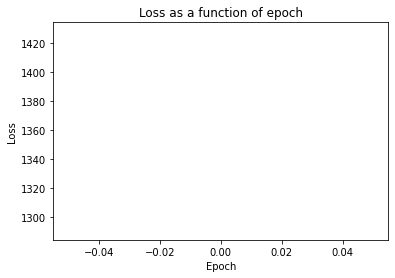

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(NUM_EPOCHS),losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss as a function of epoch")

In [ ]:
WORDS_GENERATED=10
next_iter=['of','all','human']
for i in range(WORDS_GENERATED):
    next_iter=model.predict(next_iter)

spent
public
savage
That
Silva
These
Parks
public
who
Centre


Interesting problem to think about: is there a way to account for the beginning (non-Name capital letters) and end (punctuation marks) of a sentence? And should you be removing quotation marks and comas?

In [ ]:
model.write_embedding_to_file('embeddings.npy') # defined in class CBOWModeler(nn.Module):
X = np.load('embeddings.npy')
from sklearn.manifold import TSNE
X = np.load('embeddings.npy') 
    # with the test_sentence from example 1, X should be EMBEDDING_DIM x 195
X_embedded = TSNE(n_components=2).fit_transform(X)
    # with the test_sentence from example 1, X_embedded should be 2 x 195
X_embedded.shape
plt.scatter(X_embedded[:,0],X_embedded[:,1])